# Differential cross section fitting using BRICK 
## $^{12}\rm{C}(^{12}C, \alpha_{0})^{20}\rm{Ne}$ 

## Steps
* Construct a Python object that enables the calling of AZURE2 with an arbitrary input vector $\theta$.
* Set up priors for each of the sampled parameters and a corresponding prior ($\ln\Pi$) function.
* Construct a global function that reads a SRIM file, input energy, and return the -dE/dx.
* Construct the yield function.
* Set up a likelihood ($\ln\mathcal{L}$) function.
* Construct a posterior ($\ln\mathcal{P}$) function from the likelihood and prior functions.
* Prepare the MCMC walker and sample the posterior ($\ln\mathcal{P}$) function with emcee.
* Preview the results.

In [1]:
import os
import emcee
import corner

import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import quad, quadrature
# import seaborn as sns
import matplotlib.pyplot as plt

import re
from tqdm import tqdm
from scipy import stats
from brick.azr import AZR
from multiprocess import Pool

### Step 1
* Construct a Python object that enables the calling of AZURE2 with an arbitrary input vector $\theta$.

In [ ]:
# Restrict processes to one thread only. Good for AZURE2
os.environ['OMP_NUM_THREADS'] = '1'

# Construct an object that calls AZURE2 and takes input 'a0_3.00MeV.arz'
azr = AZR('a0_3.00MeV.arz')

# How many parameters are going to be sampled?
nd = azr.config.nd + 1
print(f'There are {nd} sampled parameters.\n')

# Get the initial input parameters
# theta0 = azr.config.get_input_values()

theta0=[]
# pattern = r'G\s*=\s*(\d+\.\d+)\s*(keV|eV|meV)'
# with open('output/parameters.out', 'r') as file:
#     for line in file:
#         match = re.search(pattern, line)
#         if match:
#             value = float(match.group(1))
#             unit = match.group(2)
#             # Convert units to eV
#             if unit == 'keV':
#                 value *= 1e3
#             elif unit == 'meV':
#                 value *=1e-3
#             theta0.append(value)
for i in range(nd-1):
    theta0.append(10)

theta0.append(1E5)
print(f'The initial input parameters are:\n {theta0}\n')

# What labels have been assigned to those parameters?
labels = azr.config.labels
labels.append('$N_{v}$')
print(f'The labels of the input parameters are:\n {labels}\n')

There are 56 sampled parameters.

The initial input parameters are:
 [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100000.0]

The labels of the input parameters are:
 ['$\\Gamma_{1,1}^{(+0.0)}$', '$\\Gamma_{1,2}^{(+0.0)}$', '$\\Gamma_{1,3}^{(+0.0)}$', '$\\Gamma_{2,1}^{(+0.0)}$', '$\\Gamma_{2,2}^{(+0.0)}$', '$\\Gamma_{2,3}^{(+0.0)}$', '$\\Gamma_{3,1}^{(+0.0)}$', '$\\Gamma_{3,2}^{(+0.0)}$', '$\\Gamma_{3,3}^{(+0.0)}$', '$\\Gamma_{4,1}^{(+0.0)}$', '$\\Gamma_{4,2}^{(+0.0)}$', '$\\Gamma_{4,3}^{(+0.0)}$', '$\\Gamma_{5,1}^{(+0.0)}$', '$\\Gamma_{5,2}^{(+0.0)}$', '$\\Gamma_{5,3}^{(+0.0)}$', '$\\Gamma_{1,1}^{(+2.0)}$', '$\\Gamma_{1,2}^{(+2.0)}$', '$\\Gamma_{1,3}^{(+2.0)}$', '$\\Gamma_{1,4}^{(+2.0)}$', '$\\Gamma_{2,1}^{(+2.0)}$', '$\\Gamma_{2,2}^{(+2.0)}$', '$\\Gamma_{2,3

Text(0, 0.5, 'Yields (arb. units)')

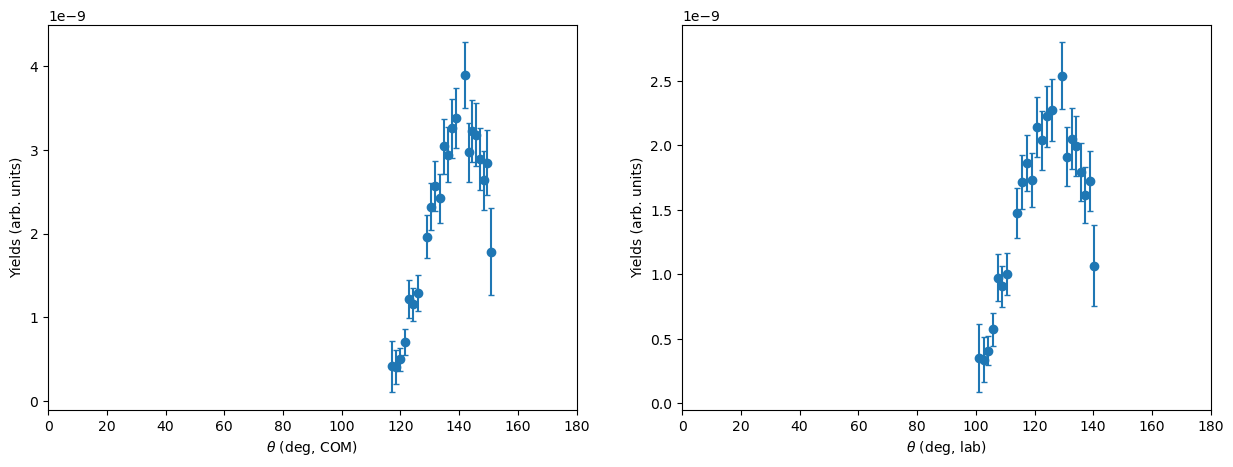

In [3]:
# We now need to do a trick to get the data files
# 'azr.predict( theta0, dress_up=False )' returns the contents in 'AZUREOut_aa=*_R=*.out'
output = np.vstack( azr.predict( theta0, dress_up=False ) )

# Now we loop over the data files to take their order and length and cut the output
index, data = 0, { } # Here, data is a dictionary
for segment in azr.config.data.segments:
    data[segment.filename] = output[index:index+len(segment.values)]
    index += len(segment.values)

E_COM       = output[:, 0] # COM energy
A_COM       = output[:, 2] # COM anlge
y = output[:, 5] # cross section
sigma_y = output[:, 6] # uncertainty of cross section

# Convert COM to Lab
m_a = 12
m_A = 12
m_b = 4
m_B = 20
Q=4.62
gamma = np.sqrt((m_a*m_b)/(m_A*m_B)*(m_b+m_B)/(m_a+m_A)*E_COM[0]/(E_COM[0]+Q))
index = 0
angle_lab, sigma_lab, sigma_lab_err = [], [], []
for sigma_COM in y:
    angle_l = np.arccos((gamma+np.cos(A_COM[index]/180*np.pi))/np.sqrt(1+gamma**2+2*gamma*np.cos(A_COM[index]/180*np.pi)))
    angle_lab.append(float(angle_l*180/np.pi))
    sigma_l = (1+gamma**2+2*gamma*np.cos(A_COM[index]/180*np.pi))**(3/2)/(1+gamma*np.cos(A_COM[index]/180*np.pi))*sigma_COM
    sigma_lab.append(sigma_l)
    sigma_lab_e = (1+gamma**2+2*gamma*np.cos(A_COM[index]/180*np.pi))**(3/2)/(1+gamma*np.cos(A_COM[index]/180*np.pi))*sigma_y[index]
    sigma_lab_err.append(sigma_lab_e)
    index+=1
num_angles = index
angle_lab = np.array(angle_lab)
sigma_lab = np.array(sigma_lab)
sigma_lab_err = np.array(sigma_lab_err)

# Take a look at the data
fig, ax = plt.subplots( 1, 2, figsize=( 15, 5 ) )
ax[0].errorbar(A_COM, y, yerr=sigma_y, linestyle='', capsize=2, fmt="o")
# ax[0].set_yscale('log')
ax[0].set_xlim(0, 180)
ax[0].set_xlabel(r'$\theta$ (deg, COM)')
ax[0].set_ylabel(r'Yields (arb. units)')

ax[1].errorbar(angle_lab, sigma_lab, yerr=sigma_lab_err, linestyle='', capsize=2, fmt="o")
ax[1].set_xlim(0, 180)
ax[1].set_xlabel(r'$\theta$ (deg, lab)')
ax[1].set_ylabel(r'Yields (arb. units)')

### Step 2
* Set up priors for each of the sampled parameters and a corresponding prior ($\ln\Pi$) function.

In [4]:
# priors = []
# for i in range(nd-1):
#    if (i == 0) or (i==4) or (i==8) or (i==12) or (i==16) or (i==20) or (i==25) or (i==30) or (i==35) or (i==40) or (i==45) or (i==50) or (i==55) or (i==60) or (i==65):
#       priors.append(stats.norm(theta0[i], 0.1*theta0[i]/2.355))
#    else:
#       priors.append(stats.uniform(0, 1E5))
# priors.append(stats.uniform(1E4,1E6))


# priors = [
#     stats.uniform(0, 1E5), #'$\\Gamma_{1,1}^{(+0.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{1,2}^{(+0.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{1,3}^{(+0.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{2,1}^{(+0.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{2,2}^{(+0.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{2,3}^{(+0.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{3,1}^{(+0.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{3,2}^{(+0.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{3,3}^{(+0.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{4,1}^{(+0.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{4,2}^{(+0.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{4,3}^{(+0.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{5,1}^{(+0.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{5,2}^{(+0.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{5,3}^{(+0.0)}$'

#     stats.uniform(0, 1E5), #'$\\Gamma_{1,1}^{(+2.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{1,2}^{(+2.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{1,3}^{(+2.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{1,4}^{(+2.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{2,1}^{(+2.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{2,2}^{(+2.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{2,3}^{(+2.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{2,4}^{(+2.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{3,1}^{(+2.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{3,2}^{(+2.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{3,3}^{(+2.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{3,4}^{(+2.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{4,1}^{(+2.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{4,2}^{(+2.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{4,3}^{(+2.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{4,4}^{(+2.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{5,1}^{(+2.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{5,2}^{(+2.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{5,3}^{(+2.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{5,4}^{(+2.0)}$'

#     stats.uniform(0, 1E5), #'$\\Gamma_{1,1}^{(+4.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{1,2}^{(+4.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{1,3}^{(+4.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{1,4}^{(+4.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{2,1}^{(+4.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{2,2}^{(+4.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{2,3}^{(+4.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{2,4}^{(+4.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{3,1}^{(+4.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{3,2}^{(+4.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{3,3}^{(+4.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{3,4}^{(+4.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{4,1}^{(+4.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{4,2}^{(+4.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{4,3}^{(+4.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{4,4}^{(+4.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{5,1}^{(+4.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{5,2}^{(+4.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{5,3}^{(+4.0)}$'
#     stats.uniform(0, 1E5), #'$\\Gamma_{5,4}^{(+4.0)}$'

#     stats.uniform(1E4,1E6) # N_{v}
# ]

priors = []
for i in range(len(theta0)-1):
    priors.append(stats.uniform(0,1E8))
priors.append(stats.uniform(1E3,1E7))

# mask = np.array([0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8]) # Widths of the Gaussians can be different.
# priors = [stats.norm(mu, abs(mu) * mask[i]) for i, mu in enumerate(theta0)]

def lnPi(theta):
    return np.sum([pi.logpdf(t) for (pi, t) in zip(priors, theta)])

### Step 3
* Construct a global function that reads a SRIM file, input energy, and return the -dE/dx.

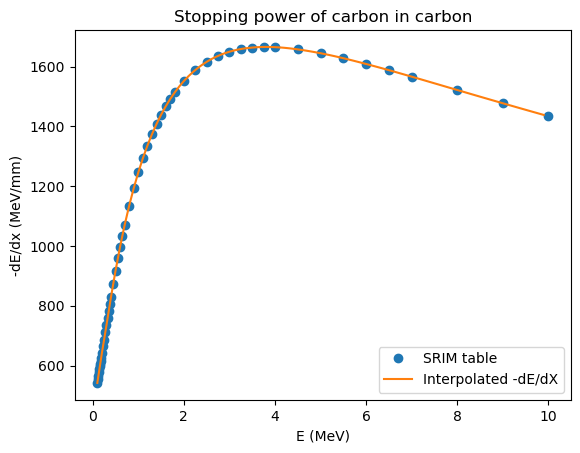

In [5]:
# Read in the SRIM table
srim_file = 'data/CarbonInCarbon.txt'
srim_table = []
with open(srim_file, 'r') as file:
    for line in file:
        cols = line.split()
        srim_table.append((float(cols[0]), float(cols[1]))) # (MeV, MeV/mm)
srim_table=np.array(srim_table)

# Construct the interpolation
srim_interp = interp1d(srim_table[:,0], srim_table[:,1],kind='cubic')
new_x = np.arange(0.1,10,0.1)
plt.figure()
plt.plot(srim_table[:,0], srim_table[:,1], 'o', label='SRIM table')
plt.plot(new_x, srim_interp(new_x), '-', label='Interpolated -dE/dX')
plt.xlabel('E (MeV)')
plt.ylabel('-dE/dx (MeV/mm)')
plt.title('Stopping power of carbon in carbon')
plt.legend()
plt.show()

### Step 4
* Construct the yield function.

$$Y_{\rm lab}(\theta_{\rm lab}; E_0)=N_{V}\int_{0}^{E_0}\left[\sigma_{\rm lab}(\theta_{\rm lab}; E)/-\frac{{\rm d} E}{{\rm d} x}\right]{\rm d} E$$

where $\sigma_{\rm lab}(\theta_{\rm lab})=\frac{(1+\gamma^2+2\gamma\cos\theta_{\rm c})^{1.5}}{1+\gamma\cos\theta_{\rm c}}\sigma_{\rm c}(\theta_{\rm c})$

In [6]:
def yield_angle(theta, angle_index):
    output = azr.extrapolate(theta[:-1],[angle_index])[0]
    energy_c = output[:,0]
    angle_c = output[:,2]
    sigma_c = output[:,3]
    energy_l=(m_a+m_A)/m_A*energy_c
    gamma_local = np.sqrt((m_a*m_b)/(m_A*m_B)*(m_b+m_B)/(m_a+m_A)*energy_c/(energy_c+Q))
    sigma_l = (1+gamma_local**2+2*gamma_local*np.cos(angle_c/180*np.pi))**(3/2)/(1+gamma_local*np.cos(angle_c/180*np.pi))*sigma_c
    # a_l=np.arccos((gamma_local+np.cos(angle_c/180*np.pi))/np.sqrt(1+gamma_local**2+2*gamma_local*np.cos(angle_c/180*np.pi)))
    sigma_interp = interp1d(energy_l, sigma_l, kind='linear')
    def integrand(E):
        return sigma_interp(E)/srim_interp(E)
    res, err = quad(integrand, 0.5, 6) # Integrate from E = 0.5 to 6 MeV
    return res * theta[-1]

### Step 5
* Set up a likelihood ($\ln\mathcal{L}$) function.

In [7]:
def lnL(theta):
    mu=[]
    for i in range(num_angles):
        mu.append(yield_angle(theta, i))
    return np.sum(-np.log(np.sqrt(2*np.pi)*sigma_lab_err) - 0.5*((sigma_lab - mu)/sigma_lab_err)**2)

### Step 6
* Construct a posterior ($\ln\mathcal{P}$) function from the likelihood and prior functions.

In [8]:
def lnP(theta):
    lnpi = lnPi( theta )                        # Calculate the prior
    if not np.isfinite( lnpi ): 
        return -np.inf  # If the prior is not finite, return -inf
    lnl = lnL( theta )                          # Calculate the likelihood
    return lnl + lnpi

### Step 7
* Prepare the MCMC walker and sample the posterior ($\ln\mathcal{P}$) function with emcee.

In [9]:
nw = 2 * nd  # number of walkers = 2 * number of sampled parameters

# Each walker needs its own starting position. We'll take normally distributed
# random values centered at theta0.
p0 = np.zeros((nw, nd))
# mask = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]) # Widths of the Gaussians can be different.
mask = np.zeros(nd)
for i in range(nd):
    mask[i] = 0.01
for i in range(nw):
    mu = theta0
    sig = np.abs(theta0) * mask
    p0[i, :] = stats.norm(mu, sig).rvs()


# We'll store the chain in chain.h5. (See emcee Backends documentation.)
backend = emcee.backends.HDFBackend("chain.h5")
backend.reset(nw, nd)

nsteps = 10  # How many saved steps should each walker make?
nthin = 1  # How often should the walkr save a step? n_total = nsteps * nthin
nprocs = nw  # How many Python processes do you want to allocate?

# For a stretch move
move = emcee.moves.StretchMove()

# emcee allows the user to specify the way the ensemble generates proposals.
with Pool(processes=24) as pool:
    sampler = emcee.EnsembleSampler(
        nw, nd, lnP, pool=pool, backend=backend, moves=[move]
    )
    state = sampler.run_mcmc(p0, nsteps, thin_by=nthin, progress=True, tune=True)

100%|██████████| 10/10 [02:16<00:00, 13.69s/it]


#### 1. Posterior function evolution

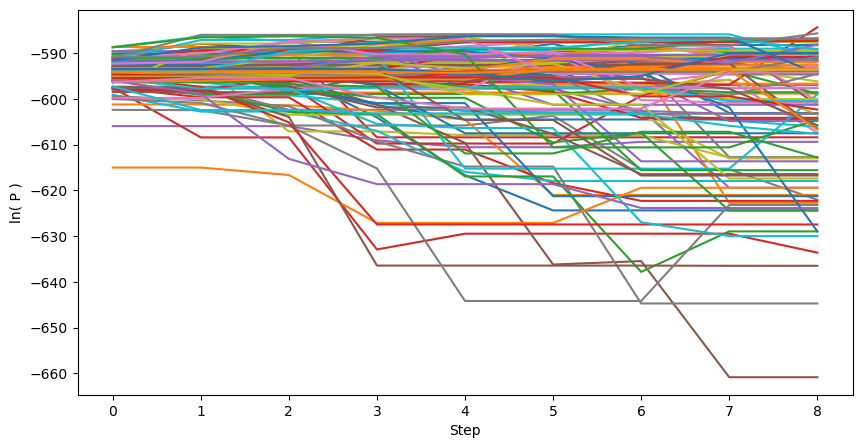

In [10]:
# Plot the probability
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

lnp = backend.get_log_prob(discard=1)
ax.plot(lnp)

ax.set_xlabel('Step')
ax.set_ylabel('ln( P )')

plt.show()

#### 2. Parameters evolution

In [ ]:
# Get the samples
nb=4000 # discard the first nb samples
flat_samples = sampler.get_chain(flat=True, discard=nb)

# Plot the parameters
fig, ax = plt.subplots( int(nd / 2)+1, 2, figsize=( 15, 30 ) )

means, lows, highs = [], [], []
final_results = np.zeros(nd)
for i in range( nd ):

        mean = np.percentile( flat_samples[:,i], 50 )
        low = np.percentile( flat_samples[:,i], 16 )
        high = np.percentile( flat_samples[:,i], 84 )
    
        ax[i//2, i%2].set_title( labels[i] )
        ax[i//2, i%2].set_xlabel( "Step" )

        ax[i//2, i%2].plot( flat_samples[:,i], color="tab:blue" )
        ax[i//2, i%2].axhline( mean, color="tab:red", linestyle="-", lw=4 )
        ax[i//2, i%2].axhline( low, color="tab:red", linestyle="--", lw=2 )
        ax[i//2, i%2].axhline( high, color="tab:red", linestyle="--", lw=2 )

        ax[i//2, i%2].set_ylabel( "Value" )

        means.append( mean )
        lows.append( low )
        highs.append( high )

# Save parameters to file
with open( "results/best-emcee.txt", "w" ) as f:
    for i in range( nd ):
        f.write( f"{azr.config.labels[i]}: {means[i]:.5f} + {highs[i]-means[i]:.5f} - {means[i]-lows[i]:.5f}\n" )

#### 3. Corner plot

In [ ]:
fig = corner.corner(
    flat_samples, labels=labels, truths=means, quantiles=[0.16, 0.5, 0.84], title_fmt=".4f", fill_contours=True,
    show_titles=True,
);

#### 4. Resampling

In [ ]:
def yield_angles(theta):
    output = azr.extrapolate(theta[:-1],[23])[0]
    split_data = np.array([output[i:i+56] for i in range(0, len(output), 56)])
    yields = np.zeros((1799,2))
    for i in range(1,1800):
        energy_c = split_data[i,:,0]
        angle_c = split_data[i,:,2]
        sigma_c = split_data[i,:,3]
        energy_l=(m_a+m_A)/m_A*energy_c
        gamma_local = np.sqrt((m_a*m_b)/(m_A*m_B)*(m_b+m_B)/(m_a+m_A)*energy_c/(energy_c+Q))
        angle_l = np.arccos((gamma_local+np.cos(angle_c/180*np.pi))/np.sqrt(1+gamma_local**2+2*gamma_local*np.cos(angle_c/180*np.pi)))
        sigma_l = (1+gamma_local**2+2*gamma_local*np.cos(angle_c/180*np.pi))**(3/2)/(1+gamma_local*np.cos(angle_c/180*np.pi))*sigma_c
        sigma_interp = interp1d(energy_l, sigma_l, kind='linear')
        def integrand(E):
            return sigma_interp(E)/srim_interp(E)
        res, err = quad(integrand, 0.5,6)
        yields[i-1,0] = np.mean(angle_l)
        yields[i-1,1] = res*theta[-1]
    return yields

# buckets = []
# np.random.shuffle( flat_samples )
# for sample in tqdm( flat_samples[-100:] ):
#     buckets.append(yield_angles(sample))
def process_parallel():
    # Shuffle and take last 100 samples
    np.random.shuffle(flat_samples)
    samples_to_process = flat_samples[-1000:]
    
    # Create a pool of workers
    with Pool(processes=24) as pool:
        # Map the function to the samples and show progress
        buckets = list(tqdm(
            pool.imap(yield_angles, samples_to_process),
            total=len(samples_to_process)
        ))
    
    return buckets
buckets = process_parallel()

In [ ]:
# Plot the reampled results and compared it to the data
buckets=np.array(buckets)

mean = np.percentile(buckets, 50, axis=0 )
low = np.percentile(buckets, 16, axis=0)
high = np.percentile(buckets, 84, axis=0)

fig, ax = plt.subplots(1,1,figsize=( 10, 5 ))
ax.errorbar(angle_lab, sigma_lab, yerr=sigma_lab_err, linestyle='', capsize=2, fmt="o")
ax.set_xlim(0, 180)
ax.set_xlabel(r'$\theta$ (deg, lab)')
ax.set_ylabel(r'Yields (arb. units)')

ax.plot(mean[:,0]*180/np.pi, mean[:,1], label="Extrapolation", color="red")
ax.fill_between(mean[:,0]*180/np.pi, low[:,1], high[:,1], color="red", alpha=0.5 )